## 0. Import Libraries

In [1]:
import glob
import cartopy

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## 1. Define Parameters

In [2]:
# general data path
general_path = 'data'

# variable name
name_var = 'TOT_PREC'

# model and observation source names
name_model = 'cosmo'
name_obs = 'era5land'

# data aggregation type
type_agg = 'monmean'

# data time information
ref_interval = np.arange(1985, 2006) # including 1985 and 2006
ref_first = ref_interval[0]
ref_last = ref_interval[-1]

# reference data paths
common_path = fr'{general_path}/{name_var}'
path_model = fr'{common_path}/{name_model}/{name_model}_{type_agg}_{ref_first}_{ref_last}.nc'
path_obs = fr'{common_path}/{name_obs}/{name_obs}_{type_agg}_{ref_first}_{ref_last}.nc'

## 2. Open Data

### 2.1 Projection Data

In [3]:
# open data to fetch projection from
dt_proj = xr.open_dataset(r'data/lffd2100123118.nc')

### 2.2 Model Data

In [4]:
# open model data
dt_model = xr.open_dataset(path_model, engine='netcdf4')

### 2.3 Observation Data

In [53]:
# open observation data
dt_obs = xr.open_dataset(path_obs, engine='netcdf4')

In [52]:
dt_obs = dt_obs.rename({'longitude':'rlon',
                        'latitude':'rlat'}
                      )

In [36]:
# rename precipitation variable for observation
dt_obs = dt_obs.rename({'tp':name_var})

## 3. Assign Projection

In [37]:
# define globe
globe = cartopy.crs.Globe(ellipse='sphere',
                          semimajor_axis=6370000,
                          semiminor_axis=6370000)

dt_x_dim = 'rlon'
dt_y_dim = 'rlat'

### 3.1 Model Data

In [38]:
# fetch model projection info
rotated_pole = dt_proj['rotated_pole']
pole_longitude = rotated_pole.attrs['grid_north_pole_longitude']
pole_latitude = rotated_pole.attrs['grid_north_pole_latitude']

In [39]:
# define model projection
proj_model = cartopy.crs.RotatedPole(pole_longitude=pole_longitude,
                               pole_latitude=pole_latitude,
                               globe=globe
                               )
proj_model.proj4_params

{'ellps': 'sphere',
 'a': 6370000,
 'b': 6370000,
 'proj': 'ob_tran',
 'o_proj': 'latlon',
 'o_lon_p': 0.0,
 'o_lat_p': 50.0,
 'lon_0': 33.0,
 'to_meter': 111177.4733520388}

In [40]:
# write projection
dt_model = dt_model.rio.write_crs(proj_model)

# set spatial dims
dt_model = dt_model.rio.set_spatial_dims(x_dim=dt_x_dim,
                                         y_dim=dt_y_dim)

In [41]:
dt_model.rio.crs

CRS.from_wkt('GEOGCRS["unnamed",BASEGEOGCRS["unknown",DATUM["unknown",ELLIPSOID["unknown",6370000,0,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]]],DERIVINGCONVERSION["unknown",METHOD["PROJ ob_tran o_proj=latlon"],PARAMETER["o_lon_p",0,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],PARAMETER["o_lat_p",50,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],PARAMETER["lon_0",33,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]],CS[ellipsoidal,2],AXIS["longitude",east,ORDER[1],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],AXIS["latitude",north,ORDER[2],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]]')

### 3.2 Observation Data

In [54]:
# define observation projection
proj_obs = cartopy.crs.CRS('EPSG:4326',
                          )
proj_obs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [55]:
# write projection
dt_obs = dt_obs.rio.write_crs(proj_obs)

# set spatial dims
dt_obs = dt_obs.rio.set_spatial_dims(x_dim=dt_x_dim,
                                     y_dim=dt_y_dim)

MissingSpatialDimensionError: x dimension (rlon) not found.

In [56]:
dt_obs = dt_obs.rio.set_spatial_dims(x_dim='longitude',
                                     y_dim='latitude')

In [49]:
dt_obs[name_var] = dt_obs[name_var].rio.set_spatial_dims(x_dim='rlon', y_dim='rlat')

In [58]:
dt_obs['tp'].rio.x_dim

'longitude'

In [15]:
dt_obs.rio.crs

CRS.from_epsg(4326)

## 4.Calculate Climatologies

### 4.1 Monthly Mean

#### 4.1.1 Model Data

In [16]:
dt_obs_monmean_clim = dt_obs.groupby('time.month').mean()*1e3 # m to mm

#### 4.1.2 Observation Data

In [17]:
dt_model_monmean_clim = dt_model.groupby('time.month').mean() # already mm (kgm**s-2)

### 4.2 Seasonally Mean

#### 4.2.1 Model Data

In [18]:
dt_obs_seasonmean_clim = dt_obs.groupby('time.season').mean()*1e3 # m to mm

#### 4.2.2 Observation Data

In [19]:
dt_model_seasonmean_clim = dt_model.groupby('time.season').mean() # already mm (kgm**s-2)

### 4.3 Annual Mean

#### 4.3.1 Model Data

In [20]:
dt_obs_annualmean_clim = dt_obs.groupby('time.year').mean()*1e3 # m to mm

#### 4.3.2 Observation Data

In [21]:
dt_model_annualmean_clim = dt_model.groupby('time.year').mean() # already mm (kgm**s-2)

## 5. Quick Look Over Data

### 5.1 Model Data

#### 5.1.1 Monthly Mean

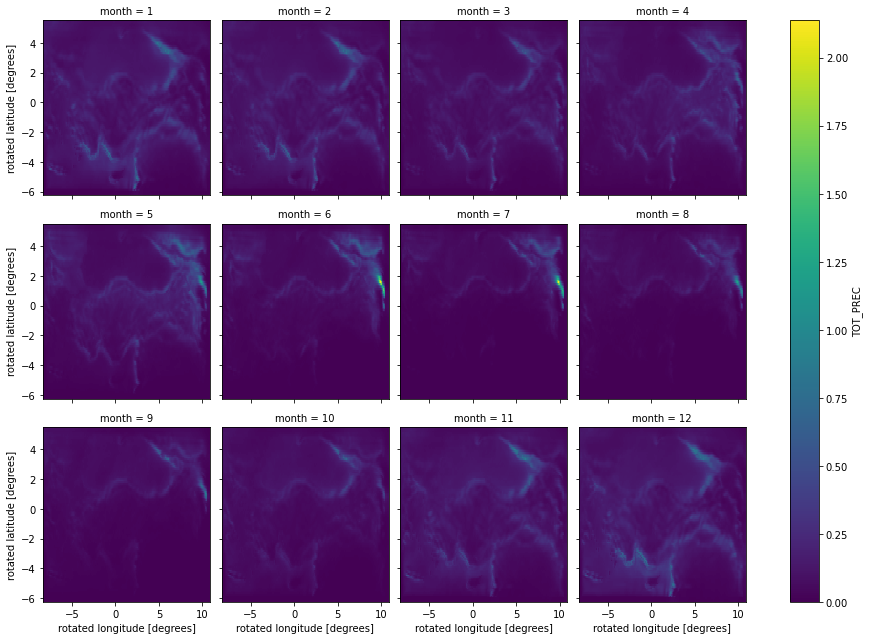

In [83]:
dt_model_monmean_clim[name_var].plot(col='month',
                                   col_wrap=4)

#### 5.1.2 Seasonally Mean

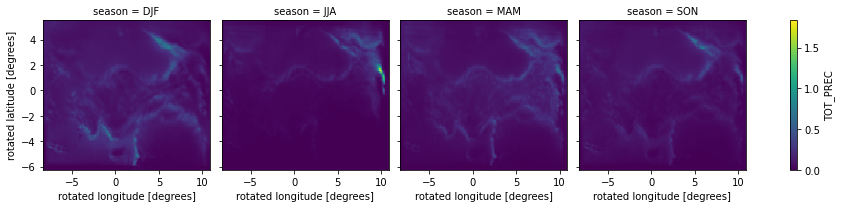

In [84]:
dt_model_seasonmean_clim[name_var].plot(col='season',
                                      col_wrap=4)

#### 5.1.3 Annual Mean

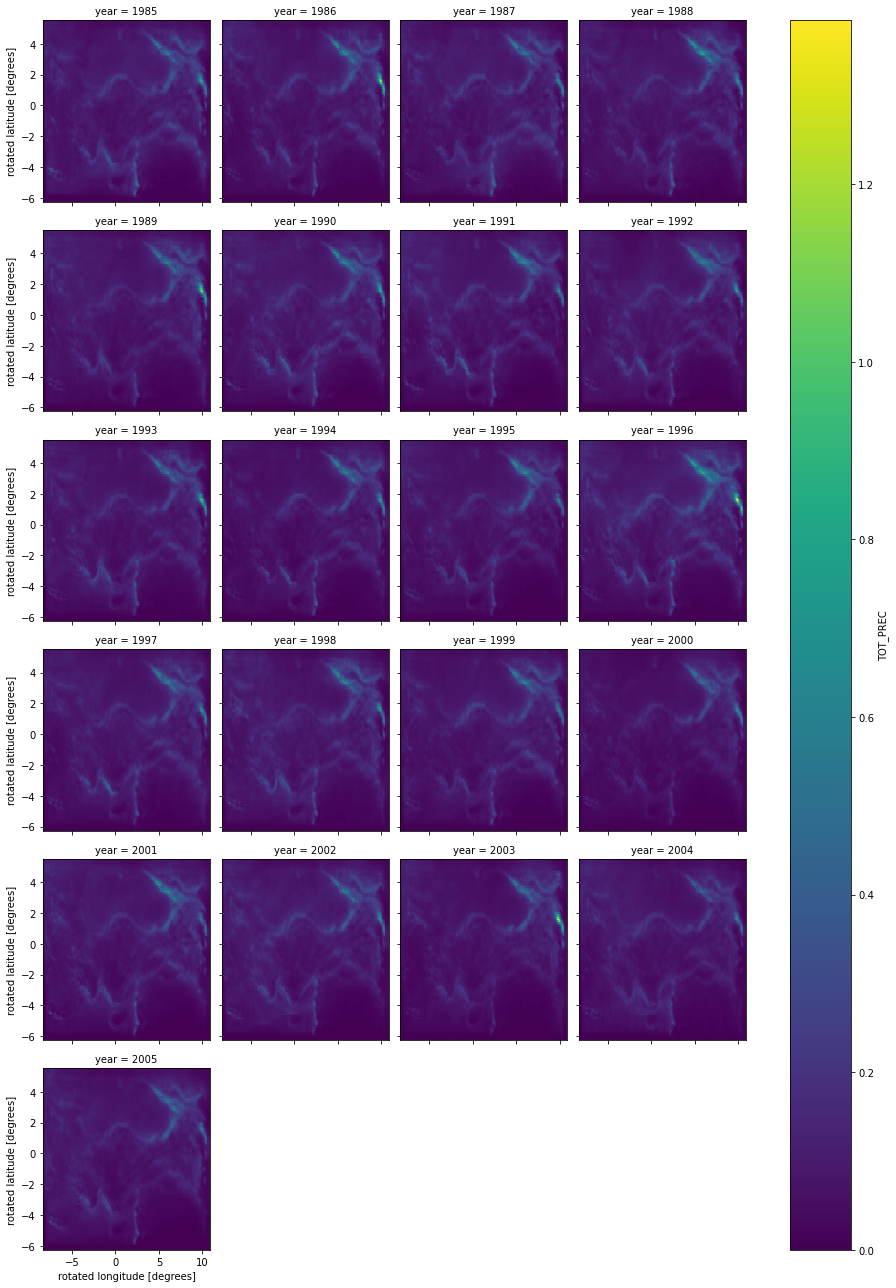

In [85]:
dt_model_annualmean_clim[name_var].plot(col='year',
                                      col_wrap=4)

### 5.2 Observation Data

#### 5.2.1 Monthly Mean

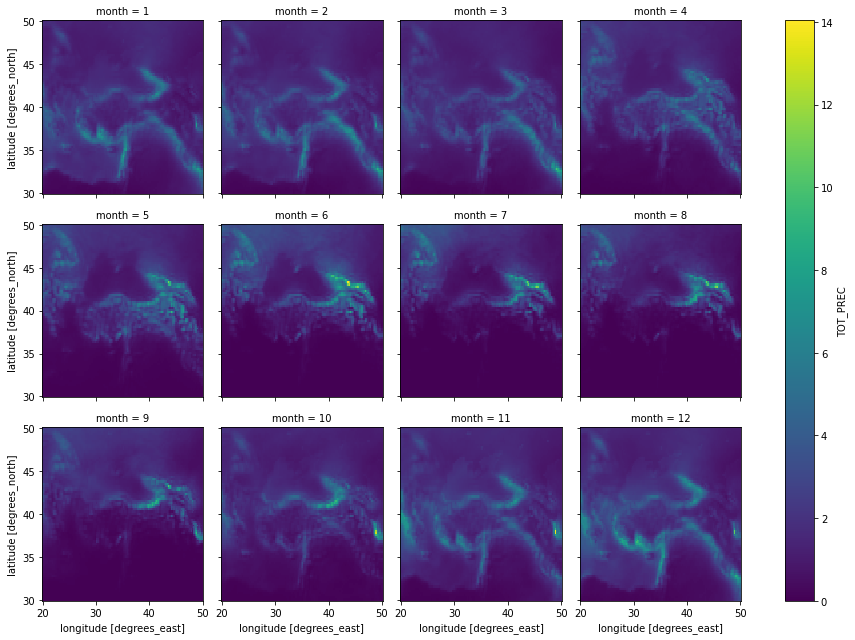

In [86]:
dt_obs_monmean_clim[name_var].plot(col='month',
                                   col_wrap=4)

#### 5.2.2 Seasonally Mean

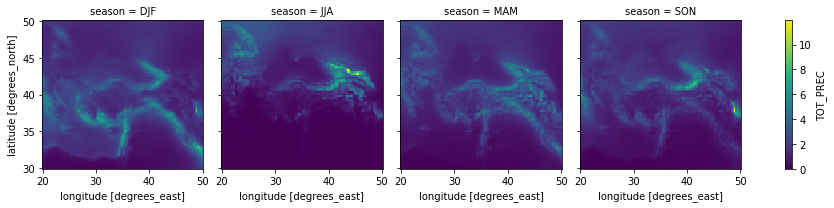

In [87]:
dt_obs_seasonmean_clim[name_var].plot(col='season',
                                      col_wrap=4)

#### 5.2.3 Annual Mean

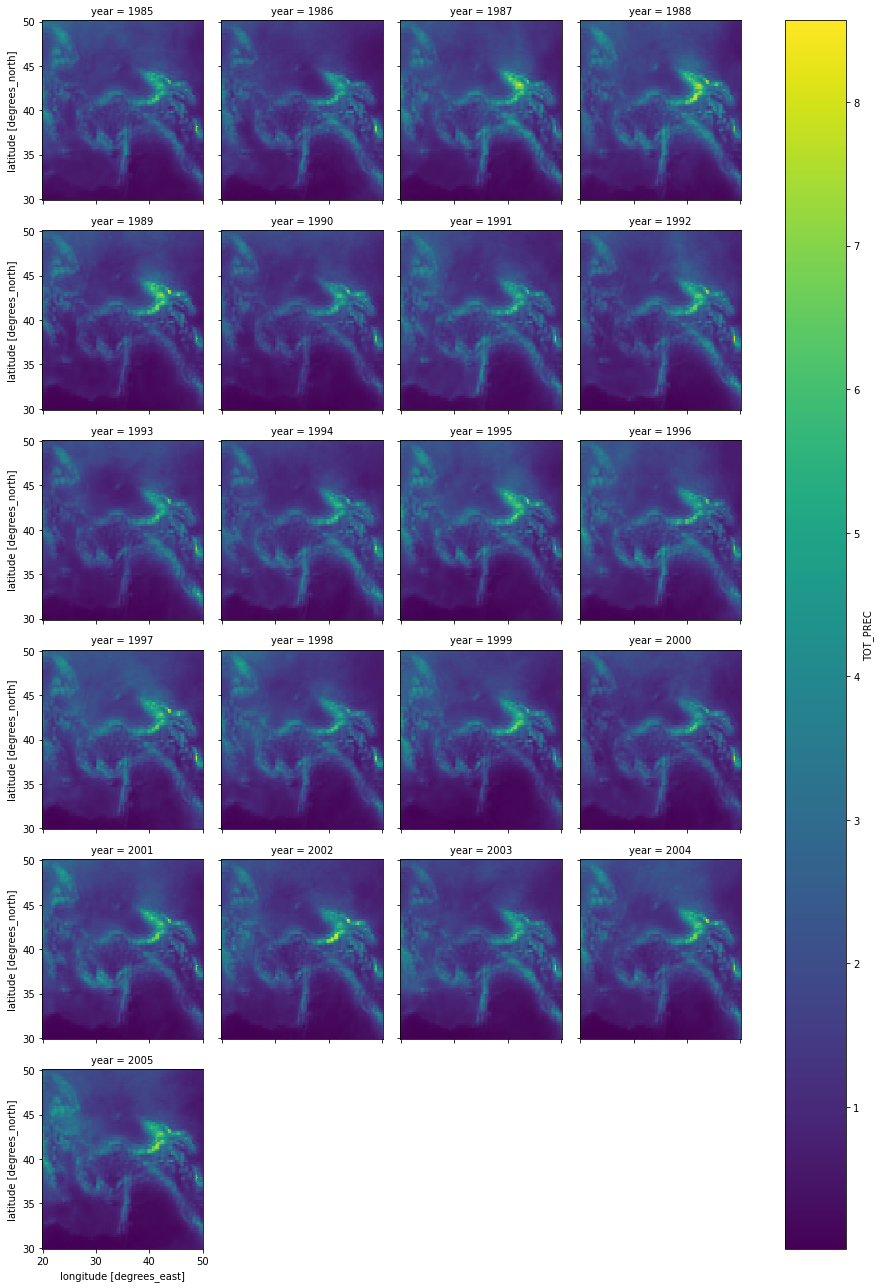

In [88]:
dt_obs_annualmean_clim[name_var].plot(col='year',
                                      col_wrap=4)

## 6. Match Grids

In [22]:
def regrid_match(dt_to_match, dt_to_be_matched):
    
    """
    Regrid a file grid to a target grid. Requires input data array
    
    Return target file and regridded file
    
    """
    # reproject
    dt_to_be_matched = dt_to_be_matched.rio.reproject_match(dt_to_match)
    
    return dt_to_be_matched

In [26]:
dt_obs_regrid = regrid_match(dt_model[name_var], dt_obs[name_var],
                             )

MissingSpatialDimensionError: x dimension not found. 'rio.set_spatial_dims()' or using 'rename()' to change the dimension name to 'x' can address this. Data variable: TOT_PREC

In [33]:
dt_obs.rio.y_dim

'rlat'